# Guarulhos Streets Orientation Analysis

Example notebook implementing OSMnx tool over all the neighborhoods of the city of Guarulhos, state of São Paulo-BR. Below will be described following analysis:

**Author**: Guilherme Fernandes Alves (https://github.com/Gui-FernandesBR)

References: https://github.com/gboeing/osmnx-examples

## Setting up the analysis

Improve matplotlib plots

In [2]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

Cloning the repository to catch shapefiles

In [3]:
!git clone https://github.com/Gui-FernandesBR/Last-Mile-Routing-Analyzer.git

fatal: destination path 'VRP-street-network' already exists and is not an empty directory.


In [4]:
import os

os.chdir("./data/shapefiles/guarulhos_neigh_osm")
os.listdir()

['guarulhos_osm.shp',
 'guarulhos_osm.prj',
 'guarulhos_osm.cpg',
 'guarulhos_osm.dbf',
 'guarulhos_osm.shx']

### Import required packages

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd

In [6]:
ox.config(log_console=True, use_cache=False)
ox.__version__

'0.11.4'

## Running the analysis

### Loading geometry file

In [7]:
# As we already chose the correct directory, we can simply import guarulhos.shp
# Please notice other guarulhos."extension" files are also important
hood_boundaries = gpd.read_file("guarulhos_osm.shp")
hood_boundaries

,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,Area,geometry
0,Cabuço de Cima,None,None,None,None,None,-1,0,-1,None,None,2.453662e+07,"POLYGON Z ((-46.53444 -23.39874 0.00000, -46.5..."
1,Cabuçu,None,None,None,None,None,-1,0,-1,None,None,1.927958e+07,"POLYGON Z ((-46.55952 -23.40104 0.00000, -46.5..."
2,Mato das Cobras,None,None,None,None,None,-1,0,-1,None,None,1.017212e+07,"POLYGON Z ((-46.40588 -23.40123 0.00000, -46.4..."
3,Morro Grande,None,None,None,None,None,-1,0,-1,None,None,5.617251e+07,"POLYGON Z ((-46.39033 -23.37362 0.00000, -46.3..."
4,Sadokim,None,None,None,None,None,-1,0,-1,None,None,2.951551e+06,"POLYGON Z ((-46.38833 -23.40590 0.00000, -46.3..."
5,Bonsucesso,None,None,None,None,None,-1,0,-1,None,None,2.085195e+07,"POLYGON Z ((-46.37056 -23.38908 0.00000, -46.3..."
6,Jardim Presidente Dutra,None,None,None,None,None,-1,0,-1,None,None,4.369456e+06,"POLYGON Z ((-46.44884 -23.43211 0.00000, -46.4..."
7,Lavras,None,None,None,None,None,-1,0,-1,None,None,2.721440e+06,"POLYGON Z ((-46.43342 -23.41459 0.00000, -46.4..."
8,Aeroporto Internacional Governador André Franc...,None,None,None,None,None,-1,0,-1,None,None,1.323795e+07,"POLYGON Z ((-46.44906 -23.41844 0.00000, -46.4..."
9,Aracília,None,None,None,None,None,-1,0,-1,None,None,2.477145e+06,"POLYGON Z ((-46.37960 -23.43413 0.00000, -46.3..."


In [8]:
# Convert geopandas object to a dictionary to be better manageable
bd_hood_dict = hood_boundaries.set_index("Name")["geometry"].to_dict()
bd_hood_dict

{'Aeroporto Internacional Governador André Franco Montoro': <shapely.geometry.polygon.Polygon at 0x7efe40d7e510>,
 'Aracília': <shapely.geometry.polygon.Polygon at 0x7efe40d7e390>,
 'Bananal': <shapely.geometry.polygon.Polygon at 0x7efe40d30d90>,
 'Bom Clima': <shapely.geometry.polygon.Polygon at 0x7efe40d73c10>,
 'Bonsucesso': <shapely.geometry.polygon.Polygon at 0x7efe40d66510>,
 'Cabuço de Cima': <shapely.geometry.polygon.Polygon at 0x7efe415853d0>,
 'Cabuçu': <shapely.geometry.polygon.Polygon at 0x7efe40d71d10>,
 'Capelinha': <shapely.geometry.polygon.Polygon at 0x7efe40d69d10>,
 'Centro': <shapely.geometry.polygon.Polygon at 0x7efe40d73f90>,
 'Cumbica': <shapely.geometry.polygon.Polygon at 0x7efe40d69290>,
 'Fátima': <shapely.geometry.polygon.Polygon at 0x7efe40d73f50>,
 'Gopoúva': <shapely.geometry.polygon.Polygon at 0x7efe40d8ae10>,
 'Itapegica': <shapely.geometry.polygon.Polygon at 0x7efe40d8ac90>,
 'Ivernada': <shapely.geometry.polygon.Polygon at 0x7efe40d27510>,
 'Jardim Pres

In [9]:
# Convert each polygon to an object of osmnx class
# The result 'container' is a dictionary including all neighborhoods geometry

container = {}
for i, j in enumerate(bd_hood_dict.keys()):
    # i = counter, and j = key
    try:
        container[j] = ox.add_edge_bearings(
            ox.graph_from_polygon(
                polygon=bd_hood_dict[j],
                network_type="all_private",
                simplify=False,
                retain_all=False,
                truncate_by_edge=False,
                name="unnamed",
                timeout=180,
                memory=None,
                max_query_area_size=50 * 1000 * 50 * 1000,
                clean_periphery=True,
                infrastructure='way["highway"]',
                custom_filter=None,
            )
        )
        print(
            i + 1,
            " conversions already concluded, the total is equal to: ",
            len(bd_hood_dict.keys()),
        )
    except KeyError:
        print(
            ">>> It was not possible to perform one conversion, check ",
            j,
            " for more details",
        )
        # "Not possible to conclude one neighborhood."
        pass

/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

1  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


2  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

3  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


4  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

5  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


6  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

7  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/p

8  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


9  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

10  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:


11  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


12  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


13  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

14  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


15  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

16  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


17  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

18  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:


19  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


20  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


21  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

22  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:


23  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:


24  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


25  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


26  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

27  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:


28  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:


29  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs


30  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


31  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

32  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


33  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/p

34  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


35  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnx/core.py:341: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:


36  conversions already concluded, the total is equal to:  36


/usr/local/lib/python3.7/dist-packages/osmnx/core.py:661: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


In [10]:
container

{'Aeroporto Internacional Governador André Franco Montoro': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe3f456e10>,
 'Aracília': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe3e92ef90>,
 'Bananal': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe35f3e350>,
 'Bom Clima': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe40420350>,
 'Bonsucesso': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe3d15b7d0>,
 'Cabuço de Cima': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe405e35d0>,
 'Cabuçu': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe3e77c150>,
 'Capelinha': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe40424550>,
 'Centro': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe40163190>,
 'Cumbica': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe3a93c590>,
 'Fátima': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe405e3590>,
 'Gopoúva': <networkx.classes.multidigraph.MultiDiGraph at 0x7efe407bbdd0>,
 'Itapegica': <networkx.clas

### Evaluate bearing compass

In [11]:
# Evaluate bearing at each and convert to a data frame
bearings_dict = {}
for i, j in enumerate(container.keys()):
    # Calculate edge bearings and visualize their frequency
    bearings = []
    for u, v, k, dt in container[j].edges(keys=True, data=True):
        try:
            bearings.append((dt["bearing"]))
        except Exception as e:
            continue
    # Convert to a pandas data frame
    bearings_dict[j] = pd.Series(bearings)

# Display all available keys
bearings_dict.keys()

dict_keys(['Cabuço de Cima', 'Cabuçu', 'Mato das Cobras', 'Morro Grande', 'Sadokim', 'Bonsucesso', 'Jardim Presidente Dutra', 'Lavras', 'Aeroporto Internacional Governador André Franco Montoro', 'Aracília', 'Capelinha', 'Cumbica', 'Pimentas', 'Água Azul', 'Água Chata', 'Bom Clima', 'Centro', 'Fátima', 'Gopoúva', 'Itapegica', 'Taboão', 'Jardim Vila Galvão', 'Monte Carmelo', 'Morros', 'Picanço', 'Ponte Grande', 'Porto da Igreja', 'Torres Tibagy', 'Vila Augusta', 'Vila Galvão', 'Vila Rio', 'Várzea do Palácio', 'Bananal', 'Ivernada', 'São João', 'Tanque Grande'])

### Visualizing single neighborhood

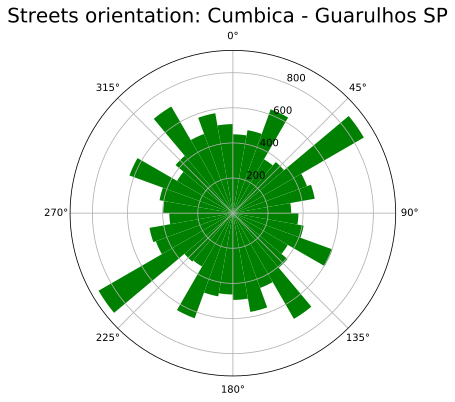

In [26]:
fig = plt.figure(figsize=(6, 6))
plt.suptitle(
    "Streets orientation: " + "Cumbica" + " - Guarulhos SP",
    fontsize=20,
    verticalalignment="top",
)

for i, j in enumerate(["Cumbica"]):
    n = 36
    count, division = np.histogram(
        bearings_dict[j], bins=[ang * 360 / n for ang in range(0, n + 1)]
    )
    division = division[0:-1]
    width = 2 * np.pi / n
    # 1 rows and 1 columns
    ax = plt.subplot(1, 1, i + 1, projection="polar", label=str(j))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction("clockwise")
    bars = ax.bar(
        division * np.pi / 180 - width * 0.5,
        count,
        width=width,
        bottom=0.0,
        color="green",
    )

plt.show()

In [27]:
ox.plot_graph(
    container["Cumbica"],
    fig_height=12,
    bgcolor="white",
    node_color="red",
    node_size=4,
    node_alpha=None,
    node_edgecolor="red",
    node_zorder=1,
    edge_color="black",
    edge_linewidth=1,
    edge_alpha=None,
    show=True,
    close=False,
    save=False,
    dpi=600,
    bbox=None,
)

Output hidden; open in https://colab.research.google.com to view.

### Visualize the whole set of street networks

In [22]:
# polar plot of all zones
fig = plt.figure(figsize=(16, 24))
# plt.suptitle("Average streets orientation by neighborhood - Guarulhos SP",
#              fontsize=20, verticalalignment='top')

for i, j in enumerate(bearings_dict.keys()):
    n = 36
    count, division = np.histogram(
        bearings_dict[j], bins=[ang * 360 / n for ang in range(0, n + 1)]
    )
    division = division[0:-1]
    width = 2 * np.pi / n
    # 6 rows and 6 columns
    ax = plt.subplot(6, 6, i + 1, projection="polar", label=str(j))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction("clockwise")
    bars = ax.bar(
        division * np.pi / 180 - width * 0.5,
        count,
        width=width,
        bottom=0.0,
        color="green",
    )
    ax.set_title(j[0:15], y=1.1)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Generate Stats

In [23]:
print(ox.basic_stats(container["Cumbica"]).keys())

n
m
k_avg
intersection_count
streets_per_node_avg
streets_per_node_counts
streets_per_node_proportion
edge_length_total
edge_length_avg
street_length_total
street_length_avg
street_segments_count
node_density_km
intersection_density_km
edge_density_km
street_density_km
circuity_avg
self_loop_proportion
clean_intersection_count
clean_intersection_density_km


In [24]:
# Save basic stats into a list of lists
matrix = []
for i, j in enumerate(container.keys()):
    c1 = ox.basic_stats(container[j])
    if i == 0:
        a = ["Name"]
        for t in list(c1.keys()):
            a.append("circuity_avg")
            a.append("clean_intersection_count")
            a.append("clean_intersection_density_km")
            a.append("edge_density_km")
            a.append("edge_length_avg")
            a.append("edge_length_total")
            a.append("intersection_count")
            a.append("intersection_density_km")
            a.append("k_avg")
            a.append("m")
            a.append("n")
            a.append("node_density_km")
            a.append("self_loop_proportion")
            a.append("street_density_km")
            a.append("street_length_avg")
            a.append("street_length_total")
            a.append("street_segments_count")
            a.append("streets_per_node_avg")
        matrix.append(a)
    row = []
    row.append(j)
    for k, l in enumerate(c1.keys()):
        # row.append(c1[k])
        row.append(c1["circuity_avg"])
        row.append(c1["clean_intersection_count"])
        row.append(c1["clean_intersection_density_km"])
        row.append(c1["edge_density_km"])
        row.append(c1["edge_length_avg"])
        row.append(c1["edge_length_total"])
        row.append(c1["intersection_count"])
        row.append(c1["intersection_density_km"])
        row.append(c1["k_avg"])
        row.append(c1["m"])
        row.append(c1["n"])
        row.append(c1["node_density_km"])
        row.append(c1["self_loop_proportion"])
        row.append(c1["street_density_km"])
        row.append(c1["street_length_avg"])
        row.append(c1["street_length_total"])
        row.append(c1["street_segments_count"])
        row.append(c1["streets_per_node_avg"])
        #'streets_per_node_counts': {0: 0, 1: 114, 2: 768, 3: 500, 4: 130},
        #'streets_per_node_proportion'
    matrix.append(row)

matrix = np.array(matrix)
matrix

array([['Name', 'circuity_avg', 'clean_intersection_count', ...,
        'street_length_total', 'street_segments_count',
        'streets_per_node_avg'],
       ['Cabuço de Cima', 0.9999991740241644, None, ..., 4431.596, 196,
        1.9898477157360406],
       ['Cabuçu', 1.0000000435111172, None, ..., 164254.9510000003, 6614,
        2.127372145384368],
       ...,
       ['Ivernada', 0.9999999563867279, None, ..., 27584.175000000003,
        1157, 2.088447653429603],
       ['São João', 1.0000001956719797, None, ..., 130136.49500000002,
        3690, 2.314930991217064],
       ['Tanque Grande', 1.0000003677868317, None, ..., 15515.371, 361,
        2.0]], dtype=object)

### Export results

In [25]:
export_file = open("export_file.csv", "w")

for i in matrix:
    for j in i:
        export_file.write(str(j))
        export_file.write("; ")
    export_file.write("\n")

export_file.close()
print("File saved!")

File saved!
